# Plotting jets as images

In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json
import uproot_methods
import copy
from coord_transform import *

In [2]:
def pseudorapidity(theta):
    return -np.log(np.tan(theta*0.5))

In [3]:
def transform_to_softdrop_axes(jetparticles,Jets):
    

    subjet0leading = (Jets.subjet0_pt > Jets.subjet1_pt)
    centroid1_pt = np.where( subjet0leading, Jets.subjet0_pt, Jets.subjet1_pt  )
    centroid1_eta = np.where( subjet0leading, Jets.subjet0_eta, Jets.subjet1_eta  )
    centroid1_phi = np.where( subjet0leading, Jets.subjet0_phi, Jets.subjet1_phi  )
    centroid1_m = np.where( subjet0leading, Jets.subjet0_m, Jets.subjet1_m  )
    centroid2_pt = np.where( subjet0leading, Jets.subjet1_pt, Jets.subjet0_pt,   )
    centroid2_eta = np.where( subjet0leading, Jets.subjet1_eta, Jets.subjet0_eta  )
    centroid2_phi = np.where( subjet0leading, Jets.subjet1_phi, Jets.subjet0_phi  )
    centroid2_m = np.where( subjet0leading, Jets.subjet1_m, Jets.subjet0_m  )
    pcentroid1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid1_pt, centroid1_eta, centroid1_phi, centroid1_m )
    pcentroid2 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid2_pt, centroid2_eta, centroid2_phi, centroid2_m )
    
    centroid1 = uproot_methods.TVector3Array.from_cartesian(pcentroid1.x, pcentroid1.y, pcentroid1.z)
    centroid2 = uproot_methods.TVector3Array.from_cartesian(pcentroid2.x, pcentroid2.y, pcentroid2.z)
    particle_p3s = uproot_methods.TVector3Array.from_cartesian(jetparticles.p4.x, jetparticles.p4.y, jetparticles.p4.z)
    #print("centroid 2 step 1 ", centroid2)
    
    # Rotate coordinate system so "centroid1" is along the x axis
    rot1_axis, rot1_angle = coord_rotation( centroid1, uproot_methods.TVector3(1,0,0) )    
    centroid1 = centroid1.rotate_axis(rot1_axis, rot1_angle)
    centroid2 = centroid2.rotate_axis(rot1_axis, rot1_angle)
    
    particle_p3s = particle_p3s.rotate_axis(rot1_axis, rot1_angle)
    #print("centroid 2 step 1:", centroid2, " theta,phi = ", centroid2.theta, ", ", centroid2.phi )


    # Now rotate about the z axis so that centroid2 is pointing down
    rot2_angle = -np.arctan2( centroid2.z, centroid2.y )
    centroid2 = centroid2.rotatex(rot2_angle)
    particle_p3s = particle_p3s.rotatex(rot2_angle)

    #rot2_axis = uproot_methods.TVector3(0,0,1)
    #rot2_angle = -centroid2.angle( uproot_methods.TVector3(0,1,0))
    #centroid2 = centroid2.rotatez(rot2_angle)
    #particle_p3s = particle_p3s.rotatez(rot2_angle)
    #print("centroid 1 :", centroid1, " theta,phi = ", centroid1.theta, ", ", centroid1.phi )
    #print("centroid 2 step 2:", centroid2, " theta,phi = ", centroid2.theta, ", ", centroid2.phi )
    
    deta = pseudorapidity(particle_p3s.theta)# - pseudorapidity(centroid1.theta)
    dphi = particle_p3s.phi# - centroid1.phi
    #print('dtheta:', dtheta)
    #print('dphi:', dphi)

    return deta,dphi,centroid1,centroid2
    

In [4]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pdgid_axis = hist.Bin("pdgid", r"PDG ID", 10000, -5000, 5000)
        eta_axis = hist.Bin("eta", r"$\eta$", 32, -5, 5)
        phi_axis = hist.Bin("phi", r"$\phi$", 32, -np.pi, np.pi)
        image_dphi = hist.Bin("image_dphi", r"$Q_1$", 256, -1, 1)
        image_deta = hist.Bin("image_deta", r"$Q_2$", 256, -1, 1)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 1000, 0, 5000)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        dr_axis = hist.Bin("dr", r"$\Delta r$", 80, 0, 0.8)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'image':hist.Hist("Counts", dataset_axis, image_dphi, image_deta),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'pdgid':hist.Hist("Counts", dataset_axis, pdgid_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        #print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            subjet0_pt=df['jet_subjet0_pt'],
            subjet0_eta=df['jet_subjet0_eta'],
            subjet0_phi=df['jet_subjet0_phi'],
            subjet0_m=df['jet_subjet0_m'],
            subjet1_pt=df['jet_subjet1_pt'],
            subjet1_eta=df['jet_subjet1_eta'],
            subjet1_phi=df['jet_subjet1_phi'],
            subjet1_m=df['jet_subjet1_m'],
            ic=df['jet_ic']
            )        
        constituents = JaggedCandidateArray.candidatesfromcounts(
            df['nConstituent'],
            pt=df['constituent_pt'],
            eta=df['constituent_eta'],
            phi=df['constituent_phi'],
            mass=df['constituent_m'],
            pdgid=df['constituent_id']
            )
        #print("particles type : ", type(particles))
        
        deta,dphi,centroid1,centroid2 = transform_to_softdrop_axes(constituents, Jets[:,0])        
        constituents.add_attributes( deta=deta )
        constituents.add_attributes( dphi=dphi )
        
        constituents = constituents[constituents.pt > 1]
        
        #print("centroid 1 ", centroid1.phi, ", ", pseudorapidity(centroid1.theta))
        #print("centroid 2 ", centroid2.phi, ", ", pseudorapidity(centroid2.theta))
        
        Jets = Jets[Jets.pt > 500]
        oneJet = (Jets.counts >=1)
        Jets = Jets[oneJet]
        constituents = constituents[oneJet]
                
        dr = Jets[:,0].p4.delta_r(constituents.p4)
        jetconstituents = constituents[dr < 0.8]
        jetconstituents = jetconstituents
        
        #dtheta_cut = np.abs( jetconstituents.dtheta ) > 0.01
        #dphi_cut = np.abs( jetconstituents.dphi ) > 0.01
        #boxcut = (dtheta_cut) | (dphi_cut)
        deta = jetconstituents.deta
        dphi = jetconstituents.dphi
        
        #print('deta : ', deta)
        #print('dphi : ', dphi)
        
        output['pt'].fill(dataset=dataset,
                            pt=Jets.pt[:,0].flatten())
        output['eta'].fill(dataset=dataset, 
                                 eta=Jets.eta[:,0].flatten())
        output['image'].fill(dataset=dataset, 
                            image_deta=deta.flatten(),
                            image_dphi=dphi.flatten())
        output['dr'].fill(dataset=dataset,dr=dr.flatten())
        output['pdgid'].fill(dataset=dataset, pdgid=jetconstituents.pdgid.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [5]:


fileset={
    'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_nsj.root'],
    #'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addsubstructure.root'],
    #'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addsubstructure.root'],
    #'QCD':'/mnt/data/ml/qcd_flat15to7000_addsubstructure.root'
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers':4, 'flatten': True},
                                  chunksize=5000#,maxchunks=1
                                  
                                 )


elapsed = time.time() - tstart
print(output)


{'pt': <Hist (dataset,pt) instance at 0x7f65c8a3ff28>, 'eta': <Hist (dataset,eta) instance at 0x7f65c8a4b0b8>, 'image': <Hist (dataset,image_dphi,image_deta) instance at 0x7f65c8a4b5c0>, 'dr': <Hist (dataset,dr) instance at 0x7f65c8a4b518>, 'pdgid': <Hist (dataset,pdgid) instance at 0x7f65c8a4b128>, 'cutflow': defaultdict(<class 'int'>, {})}


In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

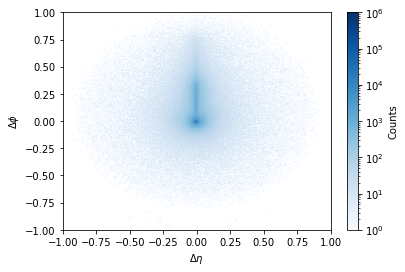

In [11]:
fig, ax, grid = hist.plot2d(output['image'].integrate('dataset'),xaxis='image_deta', patch_opts={'norm':LogNorm(vmin=1, vmax=1e6),'cmap':'Blues'})

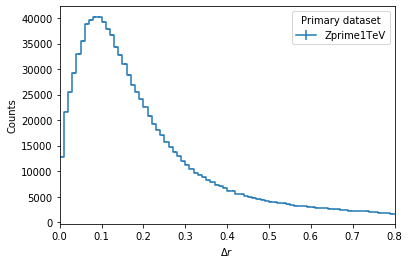

In [8]:
fig, ax = hist.plotgrid(output['dr'], overlay="dataset", stack=False
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

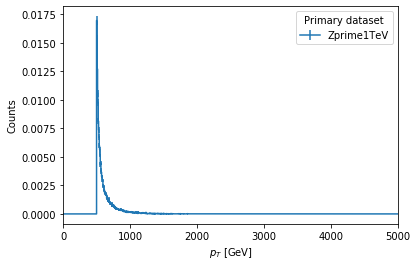

In [9]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()